In [2]:
import json

with open("OUTPUTS/legal_agent_output.json", "r", encoding="utf-8") as f:
    legal_output = json.load(f)

with open("OUTPUTS/compliance_agent_output.json", "r", encoding="utf-8") as f:
    compliance_output = json.load(f)

with open("OUTPUTS/finance_agent_output.json", "r", encoding="utf-8") as f:
    finance_output = json.load(f)

with open("OUTPUTS/operations_agent_output.json", "r", encoding="utf-8") as f:
    operations_output = json.load(f)


In [3]:
ROUTING_RULES = {
    "legal": ["termination", "governing law", "jurisdiction", "indemnity"],
    "compliance": ["gdpr", "audit", "regulatory", "data protection"],
    "finance": ["payment", "fee", "penalty", "invoice"],
    "operations": ["deliverable", "timeline", "sla", "milestone"]
}

In [4]:
def route_query(query):
    query = query.lower()
    selected_agents = set()

    for agent, keywords in ROUTING_RULES.items():
        for keyword in keywords:
            if keyword in query:
                selected_agents.add(agent)

    return list(selected_agents)


In [5]:
test_queries = [
    "Explain indemnity obligations in the contract",
    "What are the GDPR audit requirements?",
    "Describe payment penalties and invoices",
    "What are the SLA timelines?"
]

for q in test_queries:
    print(f"Query: {q}")
    print("Routed Agents:", route_query(q))
    print("-" * 50)

Query: Explain indemnity obligations in the contract
Routed Agents: ['legal']
--------------------------------------------------
Query: What are the GDPR audit requirements?
Routed Agents: ['compliance']
--------------------------------------------------
Query: Describe payment penalties and invoices
Routed Agents: ['finance']
--------------------------------------------------
Query: What are the SLA timelines?
Routed Agents: ['operations']
--------------------------------------------------


In [6]:
def coordinator_execute(query):
    agents = route_query(query)
    results = {}

    for agent in agents:
        if agent == "legal":
            results["legal"] = legal_output

        elif agent == "compliance":
            results["compliance"] = compliance_output

        elif agent == "finance":
            results["finance"] = finance_output

        elif agent == "operations":
            results["operations"] = operations_output

    return results


In [7]:
query = "Explain indemnity and termination clauses"

coordinator_result = coordinator_execute(query)

In [8]:
import pprint
pprint.pprint(coordinator_result)


{'legal': {'confidence': 0.55,
           'evidence': [{'score': 0.6870031356811523,
                         'source': 'Contract A',
                         'text': 'Termination clause: Either party may '
                                 'terminate with 30 days notice.'},
                        {'score': 0.5045853853225708,
                         'source': 'Contract B',
                         'text': 'Indemnity clause: The vendor shall indemnify '
                                 'the client for all losses.'},
                        {'score': 0.6453893184661865,
                         'source': 'Contract B',
                         'text': 'Indemnity clause: The vendor shall indemnify '
                                 'the client for all losses.'},
                        {'score': 0.3611565828323364,
                         'source': 'Contract A',
                         'text': 'Termination clause: Either party may '
                                 'terminate with 30 d

In [9]:
#LANGRAPH BASICS


In [10]:
from typing import TypedDict, Dict, Any
from langgraph.graph import StateGraph, END


In [11]:
class GraphState(TypedDict):
    query: str
    legal: Dict[str, Any]
    compliance: Dict[str, Any]

In [12]:
def legal_node(state: GraphState) -> GraphState:
    print("🟦 LEGAL AGENT RUNNING")
    print("Incoming state:", state.keys())

    state["legal"] = {
        "issues": ["termination clause", "liability clause"]
    }
    return state


def compliance_node(state: GraphState) -> GraphState:
    print("🟩 COMPLIANCE AGENT RUNNING")
    print("Incoming legal output:", state["legal"])

    state["compliance"] = {
        "gdpr": "Needs DPA",
        "risk": "Medium"
    }
    return state

In [13]:
graph = StateGraph(GraphState)


In [14]:
graph.add_node("legal_agent", legal_node)
graph.add_node("compliance_agent", compliance_node)

In [15]:
graph.set_entry_point("legal_agent")
graph.add_edge("legal_agent", "compliance_agent")
graph.add_edge("compliance_agent", END)


In [16]:
app = graph.compile()


In [17]:
input_state = {
    "query": "Review termination and GDPR clauses",
    "legal": {},
    "compliance": {}
}

result = app.invoke(input_state)
print("\nFINAL RESULT:", result)

🟦 LEGAL AGENT RUNNING
Incoming state: dict_keys(['query', 'legal', 'compliance'])
🟩 COMPLIANCE AGENT RUNNING
Incoming legal output: {'issues': ['termination clause', 'liability clause']}

FINAL RESULT: {'query': 'Review termination and GDPR clauses', 'legal': {'issues': ['termination clause', 'liability clause']}, 'compliance': {'gdpr': 'Needs DPA', 'risk': 'Medium'}}


In [18]:
graph = StateGraph(GraphState)

graph.add_node("legal_agent", legal_node)
graph.add_node("compliance_agent", compliance_node)

graph.set_entry_point("compliance_agent")
graph.add_edge("compliance_agent", "legal_agent")
graph.add_edge("legal_agent", END)

app = graph.compile()
result = app.invoke(input_state)


🟩 COMPLIANCE AGENT RUNNING
Incoming legal output: {}
🟦 LEGAL AGENT RUNNING
Incoming state: dict_keys(['query', 'legal', 'compliance'])


In [19]:
class MultiAgentState(TypedDict):
    query: str
    legal: Dict[str, Any]
    compliance: Dict[str, Any]
    finance: Dict[str, Any]
    operations: Dict[str, Any]


In [20]:
def legal_node(state: MultiAgentState):
    print("🟦 LEGAL AGENT")
    state["legal"] = {"clauses": ["termination", "liability"]}
    return state


def compliance_node(state: MultiAgentState):
    print("🟩 COMPLIANCE AGENT")
    state["compliance"] = {"gdpr": "non-compliant"}
    return state


def finance_node(state: MultiAgentState):
    print("🟨 FINANCE AGENT")
    state["finance"] = {"payment_terms": "Net 60"}
    return state


def operations_node(state: MultiAgentState):
    print("🟥 OPERATIONS AGENT")
    state["operations"] = {"sla": "99.9% uptime"}
    return state


In [21]:
graph = StateGraph(MultiAgentState)

In [22]:
graph.add_node("legal_agent", legal_node)
graph.add_node("compliance_agent", compliance_node)
graph.add_node("finance_agent", finance_node)
graph.add_node("operations_agent", operations_node)

In [23]:
graph.set_entry_point("legal_agent")
graph.add_edge("legal_agent", "compliance_agent")
graph.add_edge("compliance_agent", "finance_agent")
graph.add_edge("finance_agent", "operations_agent")
graph.add_edge("operations_agent", END)

In [24]:
app = graph.compile()

In [25]:
input_state = {
    "query": "Review termination, GDPR, payments, and SLAs",
    "legal": {},
    "compliance": {},
    "finance": {},
    "operations": {}
}

result = app.invoke(input_state)
print("\nFINAL STATE KEYS:", result.keys())
print("FINAL STATE:", result)

🟦 LEGAL AGENT
🟩 COMPLIANCE AGENT
🟨 FINANCE AGENT
🟥 OPERATIONS AGENT

FINAL STATE KEYS: dict_keys(['query', 'legal', 'compliance', 'finance', 'operations'])
FINAL STATE: {'query': 'Review termination, GDPR, payments, and SLAs', 'legal': {'clauses': ['termination', 'liability']}, 'compliance': {'gdpr': 'non-compliant'}, 'finance': {'payment_terms': 'Net 60'}, 'operations': {'sla': '99.9% uptime'}}


In [26]:
graph = StateGraph(MultiAgentState)

graph.add_node("legal_agent", legal_node)
graph.add_node("compliance_agent", compliance_node)
graph.add_node("finance_agent", finance_node)
graph.add_node("operations_agent", operations_node)

graph.set_entry_point("compliance_agent")
graph.add_edge("compliance_agent", "legal_agent")
graph.add_edge("legal_agent", "finance_agent")
graph.add_edge("finance_agent", "operations_agent")
graph.add_edge("operations_agent", END)

app = graph.compile()
result = app.invoke(input_state)

🟩 COMPLIANCE AGENT
🟦 LEGAL AGENT
🟨 FINANCE AGENT
🟥 OPERATIONS AGENT


In [27]:
graph = StateGraph(MultiAgentState)

graph.add_node("legal_agent", legal_node)
graph.add_node("compliance_agent", compliance_node)
graph.add_node("operations_agent", operations_node)

graph.set_entry_point("legal_agent")
graph.add_edge("legal_agent", "compliance_agent")
graph.add_edge("compliance_agent", "operations_agent")
graph.add_edge("operations_agent", END)

app = graph.compile()
result = app.invoke(input_state)

🟦 LEGAL AGENT
🟩 COMPLIANCE AGENT
🟥 OPERATIONS AGENT


In [28]:
#Conditional Routing in LangGraph  

In [29]:
def routing_function(state):
    """
    Returns a list of agent names to invoke based on the query.
    """
    query = state.get("query", "").lower()
    selected_agents = []

    # Keyword mapping
    keyword_map = {
        "legal": ["termination", "contract", "clause", "nda", "agreement"],
        "compliance": ["gdpr", "compliance", "regulation", "audit"],
        "finance": ["payment", "invoice", "late fee", "penalty", "budget"],
        "operations": ["logistics", "supply", "delivery", "operations"]
    }

    # Check each category
    for agent, keywords in keyword_map.items():
        if any(word in query for word in keywords):
            selected_agents.append(agent)

    return selected_agents


In [30]:
def legal_agent(state):
    state["legal"]["response"] = f"Legal analysis for: {state['query']}"
    return state

def compliance_agent(state):
    state["compliance"]["response"] = f"Compliance analysis for: {state['query']}"
    return state

def finance_agent(state):
    state["finance"]["response"] = f"Finance analysis for: {state['query']}"
    return state

def operations_agent(state):
    state["operations"]["response"] = f"Operations analysis for: {state['query']}"
    return state


In [31]:
AGENTS = {
    "legal": legal_agent,
    "compliance": compliance_agent,
    "finance": finance_agent,
    "operations": operations_agent
}

def invoke_graph(state):
    # Step 1: Determine which agents to run
    agents_to_run = routing_function(state)
    print(f"Selected Agents: {agents_to_run}")  # Observe which agents are selected

    # Step 2: Execute only selected agents
    for agent_name in agents_to_run:
        state = AGENTS[agent_name](state)

    return state


In [32]:
state1 = {
    "query": "Review termination clause",
    "legal": {},
    "compliance": {},
    "finance": {},
    "operations": {}
}

result1 = invoke_graph(state1)
print(result1.keys())
print(result1["legal"])


Selected Agents: ['legal']
dict_keys(['query', 'legal', 'compliance', 'finance', 'operations'])
{'response': 'Legal analysis for: Review termination clause'}


In [33]:
state2 = {
    "query": "Check late payment penalties",
    "legal": {},
    "compliance": {},
    "finance": {},
    "operations": {}
}

result2 = invoke_graph(state2)
print(result2.keys())
print(result2["finance"])


Selected Agents: ['finance']
dict_keys(['query', 'legal', 'compliance', 'finance', 'operations'])
{'response': 'Finance analysis for: Check late payment penalties'}


In [34]:
state3 = {
    "query": "Check GDPR compliance and payment terms",
    "legal": {},
    "compliance": {},
    "finance": {},
    "operations": {}
}

result3 = invoke_graph(state3)
print(result3.keys())
print(result3["compliance"])
print(result3["finance"])


Selected Agents: ['compliance', 'finance']
dict_keys(['query', 'legal', 'compliance', 'finance', 'operations'])
{'response': 'Compliance analysis for: Check GDPR compliance and payment terms'}
{'response': 'Finance analysis for: Check GDPR compliance and payment terms'}


In [40]:
# 1️⃣ Define keyword_map first
keyword_map = {
    "legal": ["termination", "contract", "clause", "nda", "agreement"],
    "compliance": ["gdpr", "compliance", "regulation", "audit"],
    "finance": ["payment", "invoice", "late fee", "penalty", "budget"],
    "operations": ["logistics", "supply", "delivery", "operations"]
}

# 2️⃣ Add HR keywords
keyword_map["hr"] = ["hiring", "recruitment", "employee", "payroll"]

# 3️⃣ Define AGENTS dict if not defined
AGENTS = {}

# 4️⃣ Define HR agent
def hr_agent(state):
    state["hr"] = {"response": f"HR analysis for: {state['query']}"}
    
    # Optional: log to memory
    if "memory" in state:
        state["memory"].append({
            "agent": "hr",
            "findings": [f"HR analysis for: {state['query']}"]
        })
    
    return state

# 5️⃣ Register HR agent
AGENTS["hr"] = hr_agent




In [41]:
#Conversation Memory & State Persistence (Agent Memory)

In [42]:
from typing import TypedDict, List, Dict

class GraphState(TypedDict):
    query: str
    memory: List[Dict]      # Shared memory for all agents
    legal: dict
    compliance: dict
    finance: dict
    operations: dict


In [43]:
state = GraphState(
    query="Review termination clause and check GDPR compliance",
    memory=[],  # Empty memory at start
    legal={},
    compliance={},
    finance={},
    operations={}
)


In [44]:
def log_memory(state: GraphState, agent_name: str, output: dict) -> GraphState:
    """
    Helper function to log agent output into shared memory.
    """
    state["memory"].append({
        "agent": agent_name,
        "output": output
    })
    print(f"Memory after {agent_name}: {state['memory']}")
    return state

def legal_agent(state: GraphState) -> GraphState:
    response = f"Legal analysis for: {state['query']}"
    state["legal"]["response"] = response
    state = log_memory(state, "legal", {"response": response})
    return state

def compliance_agent(state: GraphState) -> GraphState:
    response = f"Compliance analysis for: {state['query']}"
    state["compliance"]["response"] = response
    state = log_memory(state, "compliance", {"response": response})
    return state

def finance_agent(state: GraphState) -> GraphState:
    response = f"Finance analysis for: {state['query']}"
    state["finance"]["response"] = response
    state = log_memory(state, "finance", {"response": response})
    return state

def operations_agent(state: GraphState) -> GraphState:
    response = f"Operations analysis for: {state['query']}"
    state["operations"]["response"] = response
    state = log_memory(state, "operations", {"response": response})
    return state


In [45]:
def routing_function(state: GraphState) -> list:
    query = state.get("query", "").lower()
    selected_agents = []

    keyword_map = {
        "legal": ["termination", "contract", "clause", "nda", "agreement"],
        "compliance": ["gdpr", "compliance", "regulation", "audit"],
        "finance": ["payment", "invoice", "late fee", "penalty", "budget"],
        "operations": ["logistics", "supply", "delivery", "operations"]
    }

    for agent, keywords in keyword_map.items():
        if any(word in query for word in keywords):
            selected_agents.append(agent)

    return selected_agents


In [46]:
AGENTS = {
    "legal": legal_agent,
    "compliance": compliance_agent,
    "finance": finance_agent,
    "operations": operations_agent
}

def execute_graph(state: GraphState) -> GraphState:
    agents_to_run = routing_function(state)
    print(f"Agents selected for query: {agents_to_run}")

    for agent_name in agents_to_run:
        # Each agent can read memory before processing
        print(f"Memory before {agent_name}: {state['memory']}")
        state = AGENTS[agent_name](state)

    return state


In [47]:
state = GraphState(
    query="Review termination clause and check GDPR compliance",
    memory=[],
    legal={},
    compliance={},
    finance={},
    operations={}
)

final_state = execute_graph(state)


Agents selected for query: ['legal', 'compliance']
Memory before legal: []
Memory after legal: [{'agent': 'legal', 'output': {'response': 'Legal analysis for: Review termination clause and check GDPR compliance'}}]
Memory before compliance: [{'agent': 'legal', 'output': {'response': 'Legal analysis for: Review termination clause and check GDPR compliance'}}]
Memory after compliance: [{'agent': 'legal', 'output': {'response': 'Legal analysis for: Review termination clause and check GDPR compliance'}}, {'agent': 'compliance', 'output': {'response': 'Compliance analysis for: Review termination clause and check GDPR compliance'}}]


In [48]:
print("\nFinal Memory State:")
for entry in final_state["memory"]:
    print(entry)

print("\nAgent Outputs:")
print("Legal:", final_state["legal"])
print("Compliance:", final_state["compliance"])
print("Finance:", final_state["finance"])
print("Operations:", final_state["operations"])



Final Memory State:
{'agent': 'legal', 'output': {'response': 'Legal analysis for: Review termination clause and check GDPR compliance'}}
{'agent': 'compliance', 'output': {'response': 'Compliance analysis for: Review termination clause and check GDPR compliance'}}

Agent Outputs:
Legal: {'response': 'Legal analysis for: Review termination clause and check GDPR compliance'}
Compliance: {'response': 'Compliance analysis for: Review termination clause and check GDPR compliance'}
Finance: {}
Operations: {}


In [49]:
#Agent-to-Agent Communication & Validation Logic

In [50]:
from typing import TypedDict, List, Dict

class GraphState(TypedDict):
    query: str
    memory: List[Dict]        # Shared memory for all agents
    validation_notes: List[str]  # Collect collaborative validation notes
    legal: dict
    compliance: dict
    finance: dict
    operations: dict


In [51]:
state: GraphState = {
    "query": "Review termination clause, check GDPR compliance, and assess SLA terms",
    "memory": [],
    "validation_notes": [],
    "legal": {},
    "compliance": {},
    "finance": {},
    "operations": {}
}


In [52]:
def compliance_node(state: GraphState) -> GraphState:
    # Simulate extracted clauses
    output = {
        "extracted_clauses": ["GDPR data retention", "Audit logging"]
    }
    state["compliance"] = output
    
    # Write to memory
    state["memory"].append({
        "agent": "compliance",
        "findings": output["extracted_clauses"]
    })
    print(f"Memory after Compliance: {state['memory']}")
    return state


In [53]:
def finance_node(state: GraphState) -> GraphState:
    # Read compliance findings
    compliance_findings = [
        m for m in state["memory"] if m["agent"] == "compliance"
    ]
    
    # Simulate finance output
    output = {
        "extracted_clauses": ["Late payment penalties", "Invoice terms"]
    }
    state["finance"] = output
    
    # Add validation note if compliance findings exist
    if compliance_findings:
        state["validation_notes"].append(
            "Finance reviewed compliance findings for penalty conflicts."
        )
    
    # Write finance findings to memory
    state["memory"].append({
        "agent": "finance",
        "findings": output["extracted_clauses"]
    })
    print(f"Memory after Finance: {state['memory']}")
    return state


In [54]:
def legal_node(state: GraphState) -> GraphState:
    # Read previous memory for validation
    all_findings = [m["findings"] for m in state["memory"]]
    
    # Simulate legal analysis
    output = {
        "extracted_clauses": ["Termination clause", "NDA compliance"],
        "notes": ["Legal validation completed"]
    }
    state["legal"] = output
    
    # Write to memory
    state["memory"].append({
        "agent": "legal",
        "findings": output["extracted_clauses"]
    })
    
    print(f"Memory after Legal: {state['memory']}")
    return state


In [55]:
def operations_node(state: GraphState) -> GraphState:
    # Read legal findings
    legal_findings = [
        m for m in state["memory"] if m["agent"] == "legal"
    ]
    
    # Simulate operations output
    output = {
        "extracted_clauses": ["Delivery SLA", "Support response time"]
    }
    state["operations"] = output
    
    # Add validation note for SLA enforceability
    if legal_findings:
        state["validation_notes"].append(
            "Operations reviewed Legal output for SLA enforceability."
        )
    
    # Write operations findings to memory
    state["memory"].append({
        "agent": "operations",
        "findings": output["extracted_clauses"]
    })
    
    print(f"Memory after Operations: {state['memory']}")
    return state


In [56]:
from langgraph.graph import StateGraph, END

graph = StateGraph(GraphState)

graph.add_node("compliance_agent", compliance_node)
graph.add_node("finance_agent", finance_node)
graph.add_node("legal_agent", legal_node)
graph.add_node("operations_agent", operations_node)

graph.set_entry_point("compliance_agent")
graph.add_edge("compliance_agent", "finance_agent")
graph.add_edge("finance_agent", "legal_agent")
graph.add_edge("legal_agent", "operations_agent")
graph.add_edge("operations_agent", END)


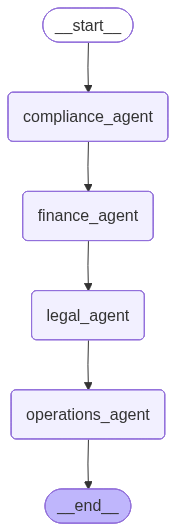

In [57]:
graph.compile()  


In [61]:
# After building your graph
compiled_graph = graph.compile()

# Now execute it with .invoke()
final_state = compiled_graph.invoke(state)

print(final_state)




Memory after Compliance: [{'agent': 'compliance', 'findings': ['GDPR data retention', 'Audit logging']}]
Memory after Finance: [{'agent': 'compliance', 'findings': ['GDPR data retention', 'Audit logging']}, {'agent': 'finance', 'findings': ['Late payment penalties', 'Invoice terms']}]
Memory after Legal: [{'agent': 'compliance', 'findings': ['GDPR data retention', 'Audit logging']}, {'agent': 'finance', 'findings': ['Late payment penalties', 'Invoice terms']}, {'agent': 'legal', 'findings': ['Termination clause', 'NDA compliance']}]
Memory after Operations: [{'agent': 'compliance', 'findings': ['GDPR data retention', 'Audit logging']}, {'agent': 'finance', 'findings': ['Late payment penalties', 'Invoice terms']}, {'agent': 'legal', 'findings': ['Termination clause', 'NDA compliance']}, {'agent': 'operations', 'findings': ['Delivery SLA', 'Support response time']}]
{'query': 'Review termination clause, check GDPR compliance, and assess SLA terms', 'memory': [{'agent': 'compliance', 'fin

In [62]:
print("\nFinal Memory State:")
for entry in final_state["memory"]:
    print(entry)

print("\nValidation Notes:")
for note in final_state["validation_notes"]:
    print(note)

print("\nAgent Outputs:")
print("Legal:", final_state["legal"])
print("Compliance:", final_state["compliance"])
print("Finance:", final_state["finance"])
print("Operations:", final_state["operations"])



Final Memory State:
{'agent': 'compliance', 'findings': ['GDPR data retention', 'Audit logging']}
{'agent': 'finance', 'findings': ['Late payment penalties', 'Invoice terms']}
{'agent': 'legal', 'findings': ['Termination clause', 'NDA compliance']}
{'agent': 'operations', 'findings': ['Delivery SLA', 'Support response time']}

Validation Notes:
Finance reviewed compliance findings for penalty conflicts.
Operations reviewed Legal output for SLA enforceability.

Agent Outputs:
Legal: {'extracted_clauses': ['Termination clause', 'NDA compliance'], 'notes': ['Legal validation completed']}
Compliance: {'extracted_clauses': ['GDPR data retention', 'Audit logging']}
Finance: {'extracted_clauses': ['Late payment penalties', 'Invoice terms']}
Operations: {'extracted_clauses': ['Delivery SLA', 'Support response time']}


In [63]:
#PIPELINES

In [64]:
#COMPILANCE PIPELINE

In [65]:
COMPLIANCE_QUERY = """
Identify clauses related to:
- Regulatory compliance
- Data protection
- Audits and reporting
"""


In [ ]:

retrieval_keywords = ["compliance", "gdpr", "data protection", "audit", "regulation"]

def retrieve_compliance_context(query: str, keywords: list) -> list:
    """
    Simulate retrieval of relevant contract/legal chunks based on keywords.
    """
    
    simulated_chunks = [
        {"text": "Clause: GDPR data retention policy", "confidence": 0.95},
        {"text": "Clause: Audit reporting requirements", "confidence": 0.92},
        {"text": "Clause: Regulatory compliance responsibilities", "confidence": 0.90},
        {"text": "Clause: Miscellaneous contract terms", "confidence": 0.40},
    ]
    
    filtered = [c for c in simulated_chunks if any(k.lower() in c["text"].lower() for k in keywords)]
    return filtered


retrieved_chunks = retrieve_compliance_context(COMPLIANCE_QUERY, retrieval_keywords)
print("Retrieved Chunks:")
for chunk in retrieved_chunks:
    print(chunk)


Retrieved Chunks:
{'text': 'Clause: GDPR data retention policy', 'confidence': 0.95}
{'text': 'Clause: Audit reporting requirements', 'confidence': 0.92}
{'text': 'Clause: Regulatory compliance responsibilities', 'confidence': 0.9}


In [67]:
def combine_chunks(chunks: list) -> str:
    """
    Combine retrieved chunks into a single text input for the agent.
    """
    return "\n".join([c["text"] for c in chunks])

combined_context = combine_chunks(retrieved_chunks)
print("\nCombined Context:\n", combined_context)



Combined Context:
 Clause: GDPR data retention policy
Clause: Audit reporting requirements
Clause: Regulatory compliance responsibilities


In [68]:
def compliance_agent(state):
    """
    Simulated compliance agent: extracts compliance clauses from combined context.
    """
    extracted_clauses = []
    for line in state["context"].split("\n"):
        if "Clause:" in line:
            extracted_clauses.append(line.replace("Clause:", "").strip())
    
    state["compliance"] = {
        "extracted_clauses": extracted_clauses,
        "num_clauses": len(extracted_clauses)
    }
    return state

# Initialize state
state = {
    "query": COMPLIANCE_QUERY,
    "context": combined_context,
    "compliance": {}
}

# Run agent
state = compliance_agent(state)
print("\nCompliance Agent Output:\n", state["compliance"])



Compliance Agent Output:
 {'extracted_clauses': ['GDPR data retention policy', 'Audit reporting requirements', 'Regulatory compliance responsibilities'], 'num_clauses': 3}


In [69]:
def validate_compliance(state, chunks):
    """
    Validate extracted clauses using confidence scores from retrieval.
    """
    validation = []
    for clause in state["compliance"]["extracted_clauses"]:
        # Find matching chunk for confidence
        match = next((c for c in chunks if clause in c["text"]), None)
        confidence = match["confidence"] if match else 0.0
        validation.append({"clause": clause, "confidence": confidence})
    
    state["compliance"]["validation"] = validation
    return state

state = validate_compliance(state, retrieved_chunks)
print("\nValidated Compliance Output:")
for v in state["compliance"]["validation"]:
    print(v)



Validated Compliance Output:
{'clause': 'GDPR data retention policy', 'confidence': 0.95}
{'clause': 'Audit reporting requirements', 'confidence': 0.92}
{'clause': 'Regulatory compliance responsibilities', 'confidence': 0.9}


In [70]:
def compliance_risk_summary(state):
    """
    Summarize high-risk clauses (confidence < 0.9 considered risky here)
    """
    risky_clauses = [v for v in state["compliance"]["validation"] if v["confidence"] < 0.9]
    state["compliance"]["risk_summary"] = {
        "num_risky_clauses": len(risky_clauses),
        "risky_clauses": risky_clauses
    }
    return state

state = compliance_risk_summary(state)
print("\nCompliance Risk Summary:")
print(state["compliance"]["risk_summary"])



Compliance Risk Summary:
{'num_risky_clauses': 0, 'risky_clauses': []}


In [71]:
def package_output(state):
    """
    Prepare final clean output for reporting
    """
    output = {
        "query": state["query"],
        "clauses": state["compliance"]["extracted_clauses"],
        "validation": state["compliance"]["validation"],
        "risk_summary": state["compliance"]["risk_summary"]
    }
    return output

final_output = package_output(state)
print("\nFinal Compliance Pipeline Output:")
print(final_output)



Final Compliance Pipeline Output:
{'query': '\nIdentify clauses related to:\n- Regulatory compliance\n- Data protection\n- Audits and reporting\n', 'clauses': ['GDPR data retention policy', 'Audit reporting requirements', 'Regulatory compliance responsibilities'], 'validation': [{'clause': 'GDPR data retention policy', 'confidence': 0.95}, {'clause': 'Audit reporting requirements', 'confidence': 0.92}, {'clause': 'Regulatory compliance responsibilities', 'confidence': 0.9}], 'risk_summary': {'num_risky_clauses': 0, 'risky_clauses': []}}


In [83]:
retrieval_keywords = ["gdpr", "audit"]

retrieved_chunks = retrieve_compliance_context(COMPLIANCE_QUERY, retrieval_keywords)

print("Retrieved Chunks for keywords:", retrieval_keywords)
if not retrieved_chunks:
    print("No chunks matched the keywords!")
else:
    for chunk in retrieved_chunks:
        print(chunk)


Retrieved Chunks for keywords: ['gdpr', 'audit']
{'text': 'Clause: GDPR data retention policy', 'confidence': 0.95}
{'text': 'Clause: Audit reporting requirements', 'confidence': 0.92}


In [72]:
#FINANCE PIPELINE


In [73]:
FINANCE_QUERY = """
Identify clauses related to:
- Payment terms
- Late fees or penalties
- Interest on overdue payments
"""


In [74]:
# Retrieval keywords
retrieval_keywords = ["payment", "invoice", "late fee", "penalty", "budget", "interest"]

def retrieve_finance_context(query: str, keywords: list) -> list:
    """
    Simulate retrieval of relevant financial clauses.
    """
    # Example chunks with confidence scores
    simulated_chunks = [
        {"text": "Clause: Payment due within 30 days", "confidence": 0.95},
        {"text": "Clause: Late payment incurs a 5% fee", "confidence": 0.90},
        {"text": "Clause: Interest accrues at 1% per month overdue", "confidence": 0.92},
        {"text": "Clause: General contract terms", "confidence": 0.40},
    ]
    
    # Filter chunks containing any of the keywords
    filtered = [c for c in simulated_chunks if any(k.lower() in c["text"].lower() for k in keywords)]
    return filtered

# Retrieve context
retrieved_chunks = retrieve_finance_context(FINANCE_QUERY, retrieval_keywords)
print("Retrieved Finance Chunks:")
for chunk in retrieved_chunks:
    print(chunk)


Retrieved Finance Chunks:
{'text': 'Clause: Payment due within 30 days', 'confidence': 0.95}
{'text': 'Clause: Late payment incurs a 5% fee', 'confidence': 0.9}
{'text': 'Clause: Interest accrues at 1% per month overdue', 'confidence': 0.92}


In [75]:
def combine_chunks(chunks: list) -> str:
    """
    Combine retrieved chunks into a single input for the agent.
    """
    return "\n".join([c["text"] for c in chunks])

combined_context = combine_chunks(retrieved_chunks)
print("\nCombined Finance Context:\n", combined_context)



Combined Finance Context:
 Clause: Payment due within 30 days
Clause: Late payment incurs a 5% fee
Clause: Interest accrues at 1% per month overdue


In [76]:
def finance_agent(state):
    """
    Extract payment-related clauses from combined context.
    """
    extracted_clauses = []
    for line in state["context"].split("\n"):
        if "Clause:" in line:
            extracted_clauses.append(line.replace("Clause:", "").strip())
    
    state["finance"] = {
        "extracted_clauses": extracted_clauses,
        "num_clauses": len(extracted_clauses)
    }
    return state

# Initialize state
state = {
    "query": FINANCE_QUERY,
    "context": combined_context,
    "finance": {}
}

# Run agent
state = finance_agent(state)
print("\nFinance Agent Output:\n", state["finance"])



Finance Agent Output:
 {'extracted_clauses': ['Payment due within 30 days', 'Late payment incurs a 5% fee', 'Interest accrues at 1% per month overdue'], 'num_clauses': 3}


In [77]:
def validate_finance(state, chunks):
    """
    Validate extracted clauses using confidence scores.
    """
    validation = []
    for clause in state["finance"]["extracted_clauses"]:
        match = next((c for c in chunks if clause in c["text"]), None)
        confidence = match["confidence"] if match else 0.0
        validation.append({"clause": clause, "confidence": confidence})
    
    state["finance"]["validation"] = validation
    return state

state = validate_finance(state, retrieved_chunks)
print("\nValidated Finance Output:")
for v in state["finance"]["validation"]:
    print(v)



Validated Finance Output:
{'clause': 'Payment due within 30 days', 'confidence': 0.95}
{'clause': 'Late payment incurs a 5% fee', 'confidence': 0.9}
{'clause': 'Interest accrues at 1% per month overdue', 'confidence': 0.92}


In [78]:
def finance_risk_summary(state):
    """
    Identify high-risk clauses (confidence < 0.9 considered risky here)
    """
    risky_clauses = [v for v in state["finance"]["validation"] if v["confidence"] < 0.9]
    state["finance"]["risk_summary"] = {
        "num_risky_clauses": len(risky_clauses),
        "risky_clauses": risky_clauses
    }
    return state

state = finance_risk_summary(state)
print("\nFinance Risk Summary:")
print(state["finance"]["risk_summary"])



Finance Risk Summary:
{'num_risky_clauses': 0, 'risky_clauses': []}


In [79]:
def package_output(state):
    """
    Prepare final output for reporting
    """
    output = {
        "query": state["query"],
        "clauses": state["finance"]["extracted_clauses"],
        "validation": state["finance"]["validation"],
        "risk_summary": state["finance"]["risk_summary"]
    }
    return output

final_output = package_output(state)
print("\nFinal Finance Pipeline Output:")
print(final_output)



Final Finance Pipeline Output:
{'query': '\nIdentify clauses related to:\n- Payment terms\n- Late fees or penalties\n- Interest on overdue payments\n', 'clauses': ['Payment due within 30 days', 'Late payment incurs a 5% fee', 'Interest accrues at 1% per month overdue'], 'validation': [{'clause': 'Payment due within 30 days', 'confidence': 0.95}, {'clause': 'Late payment incurs a 5% fee', 'confidence': 0.9}, {'clause': 'Interest accrues at 1% per month overdue', 'confidence': 0.92}], 'risk_summary': {'num_risky_clauses': 0, 'risky_clauses': []}}


In [82]:
retrieval_keywords = ["payment", "invoice", "late fee", "penalty", "budget", "interest"]

retrieved_chunks = retrieve_finance_context(FINANCE_QUERY, retrieval_keywords)

print("Retrieved Finance Chunks:")
if not retrieved_chunks:
    print("No chunks matched the keywords!")
else:
    for chunk in retrieved_chunks:
        print(chunk)


Retrieved Finance Chunks:
{'text': 'Clause: Payment due within 30 days', 'confidence': 0.95}
{'text': 'Clause: Late payment incurs a 5% fee', 'confidence': 0.9}
{'text': 'Clause: Interest accrues at 1% per month overdue', 'confidence': 0.92}


In [84]:
#LEGAL PIPELINE

In [85]:
LEGAL_QUERY = """
Identify clauses related to:
- Contract obligations
- Termination clauses
- Indemnity and liability
"""


In [86]:
# Add legal-specific keywords, including the new one
retrieval_keywords = ["termination", "contract", "clause", "nda", "agreement", "indemnification"]

def retrieve_legal_context(query: str, keywords: list) -> list:
    """
    Simulate retrieval of legal clauses from a RAG system.
    """
    simulated_chunks = [
        {"text": "Clause: Either party may terminate with 30 days notice", "confidence": 0.95},
        {"text": "Clause: The vendor shall indemnify the client for all losses", "confidence": 0.92},
        {"text": "Clause: Confidentiality NDA applies for 2 years", "confidence": 0.90},
        {"text": "Clause: Payment due within 30 days", "confidence": 0.40},
        {"text": "Clause: Delivery obligations and penalties", "confidence": 0.85},
    ]
    
    # Filter chunks matching keywords
    filtered = [
        c for c in simulated_chunks
        if any(k.lower() in c["text"].lower() for k in keywords)
    ]
    return filtered

# Retrieve context
retrieved_chunks = retrieve_legal_context(LEGAL_QUERY, retrieval_keywords)

# Print retrieved chunks
print("Retrieved Legal Chunks:")
if not retrieved_chunks:
    print("No chunks matched the keywords!")
else:
    for chunk in retrieved_chunks:
        print(chunk)


Retrieved Legal Chunks:
{'text': 'Clause: Either party may terminate with 30 days notice', 'confidence': 0.95}
{'text': 'Clause: The vendor shall indemnify the client for all losses', 'confidence': 0.92}
{'text': 'Clause: Confidentiality NDA applies for 2 years', 'confidence': 0.9}
{'text': 'Clause: Payment due within 30 days', 'confidence': 0.4}
{'text': 'Clause: Delivery obligations and penalties', 'confidence': 0.85}


In [87]:
def combine_chunks(chunks: list) -> str:
    """
    Combine retrieved chunks into a single text input for the agent.
    """
    return "\n".join([c["text"] for c in chunks])

combined_context = combine_chunks(retrieved_chunks)
print("\nCombined Legal Context:\n", combined_context)



Combined Legal Context:
 Clause: Either party may terminate with 30 days notice
Clause: The vendor shall indemnify the client for all losses
Clause: Confidentiality NDA applies for 2 years
Clause: Payment due within 30 days
Clause: Delivery obligations and penalties


In [88]:
def legal_agent(state):
    """
    Extract legal clauses from combined context.
    """
    extracted_clauses = []
    for line in state["context"].split("\n"):
        if "Clause:" in line:
            extracted_clauses.append(line.replace("Clause:", "").strip())
    
    state["legal"] = {
        "extracted_clauses": extracted_clauses,
        "num_clauses": len(extracted_clauses)
    }
    return state

# Initialize state
state = {
    "query": LEGAL_QUERY,
    "context": combined_context,
    "legal": {}
}

# Run agent
state = legal_agent(state)
print("\nLegal Agent Output:\n", state["legal"])



Legal Agent Output:
 {'extracted_clauses': ['Either party may terminate with 30 days notice', 'The vendor shall indemnify the client for all losses', 'Confidentiality NDA applies for 2 years', 'Payment due within 30 days', 'Delivery obligations and penalties'], 'num_clauses': 5}


In [89]:
def validate_legal(state, chunks):
    """
    Validate extracted clauses using confidence scores.
    """
    validation = []
    for clause in state["legal"]["extracted_clauses"]:
        match = next((c for c in chunks if clause in c["text"]), None)
        confidence = match["confidence"] if match else 0.0
        validation.append({"clause": clause, "confidence": confidence})
    
    state["legal"]["validation"] = validation
    return state

state = validate_legal(state, retrieved_chunks)
print("\nValidated Legal Output:")
for v in state["legal"]["validation"]:
    print(v)



Validated Legal Output:
{'clause': 'Either party may terminate with 30 days notice', 'confidence': 0.95}
{'clause': 'The vendor shall indemnify the client for all losses', 'confidence': 0.92}
{'clause': 'Confidentiality NDA applies for 2 years', 'confidence': 0.9}
{'clause': 'Payment due within 30 days', 'confidence': 0.4}
{'clause': 'Delivery obligations and penalties', 'confidence': 0.85}


In [90]:
def legal_risk_summary(state):
    """
    Identify clauses with lower confidence (e.g., <0.9 considered risky).
    """
    risky_clauses = [v for v in state["legal"]["validation"] if v["confidence"] < 0.9]
    state["legal"]["risk_summary"] = {
        "num_risky_clauses": len(risky_clauses),
        "risky_clauses": risky_clauses
    }
    return state

state = legal_risk_summary(state)
print("\nLegal Risk Summary:")
print(state["legal"]["risk_summary"])



Legal Risk Summary:
{'num_risky_clauses': 2, 'risky_clauses': [{'clause': 'Payment due within 30 days', 'confidence': 0.4}, {'clause': 'Delivery obligations and penalties', 'confidence': 0.85}]}


In [91]:
def package_output(state):
    """
    Prepare final structured output for reporting.
    """
    output = {
        "query": state["query"],
        "clauses": state["legal"]["extracted_clauses"],
        "validation": state["legal"]["validation"],
        "risk_summary": state["legal"]["risk_summary"]
    }
    return output

final_output = package_output(state)
print("\nFinal Legal Pipeline Output:")
print(final_output)



Final Legal Pipeline Output:
{'query': '\nIdentify clauses related to:\n- Contract obligations\n- Termination clauses\n- Indemnity and liability\n', 'clauses': ['Either party may terminate with 30 days notice', 'The vendor shall indemnify the client for all losses', 'Confidentiality NDA applies for 2 years', 'Payment due within 30 days', 'Delivery obligations and penalties'], 'validation': [{'clause': 'Either party may terminate with 30 days notice', 'confidence': 0.95}, {'clause': 'The vendor shall indemnify the client for all losses', 'confidence': 0.92}, {'clause': 'Confidentiality NDA applies for 2 years', 'confidence': 0.9}, {'clause': 'Payment due within 30 days', 'confidence': 0.4}, {'clause': 'Delivery obligations and penalties', 'confidence': 0.85}], 'risk_summary': {'num_risky_clauses': 2, 'risky_clauses': [{'clause': 'Payment due within 30 days', 'confidence': 0.4}, {'clause': 'Delivery obligations and penalties', 'confidence': 0.85}]}}


In [ ]:
#OPERATIONS AGENT

In [92]:
OPERATIONS_QUERY = """
Identify clauses related to:
- Operational obligations
- Timelines and deliverables
- Service execution
"""


In [93]:
# Retrieval keywords including "uptime"
retrieval_keywords = ["logistics", "delivery", "operations", "uptime"]

def retrieve_operations_context(query: str, keywords: list) -> list:
    """
    Simulate retrieval of operations-related clauses from a RAG system.
    """
    simulated_chunks = [
        {"text": "Clause: Delivery must occur within 15 business days", "confidence": 0.95},
        {"text": "Clause: Supplier shall maintain 99.9% uptime", "confidence": 0.92},
        {"text": "Clause: Operations team to submit weekly reports", "confidence": 0.90},
        {"text": "Clause: Payment terms and penalties apply", "confidence": 0.40},
    ]
    
    # Filter only chunks containing any of the keywords
    filtered = [
        c for c in simulated_chunks
        if any(k.lower() in c["text"].lower() for k in keywords)
    ]
    return filtered

# Retrieve context
retrieved_chunks = retrieve_operations_context(OPERATIONS_QUERY, retrieval_keywords)

# Print retrieved chunks
print("Retrieved Operations Chunks:")
if not retrieved_chunks:
    print("No chunks matched the keywords!")
else:
    for chunk in retrieved_chunks:
        print(chunk)


Retrieved Operations Chunks:
{'text': 'Clause: Delivery must occur within 15 business days', 'confidence': 0.95}
{'text': 'Clause: Supplier shall maintain 99.9% uptime', 'confidence': 0.92}
{'text': 'Clause: Operations team to submit weekly reports', 'confidence': 0.9}


In [94]:
def combine_chunks(chunks: list) -> str:
    """
    Combine retrieved chunks into a single text input for the agent.
    """
    return "\n".join([c["text"] for c in chunks])

combined_context = combine_chunks(retrieved_chunks)
print("\nCombined Operations Context:\n", combined_context)



Combined Operations Context:
 Clause: Delivery must occur within 15 business days
Clause: Supplier shall maintain 99.9% uptime
Clause: Operations team to submit weekly reports


In [95]:
def operations_agent(state):
    """
    Extract operations clauses from combined context.
    """
    extracted_clauses = []
    for line in state["context"].split("\n"):
        if "Clause:" in line:
            extracted_clauses.append(line.replace("Clause:", "").strip())
    
    state["operations"] = {
        "extracted_clauses": extracted_clauses,
        "num_clauses": len(extracted_clauses)
    }
    return state

# Initialize state
state = {
    "query": OPERATIONS_QUERY,
    "context": combined_context,
    "operations": {}
}

# Run agent
state = operations_agent(state)
print("\nOperations Agent Output:\n", state["operations"])



Operations Agent Output:
 {'extracted_clauses': ['Delivery must occur within 15 business days', 'Supplier shall maintain 99.9% uptime', 'Operations team to submit weekly reports'], 'num_clauses': 3}


In [96]:
def validate_operations(state, chunks):
    """
    Validate extracted clauses using confidence scores.
    """
    validation = []
    for clause in state["operations"]["extracted_clauses"]:
        match = next((c for c in chunks if clause in c["text"]), None)
        confidence = match["confidence"] if match else 0.0
        validation.append({"clause": clause, "confidence": confidence})
    
    state["operations"]["validation"] = validation
    return state

state = validate_operations(state, retrieved_chunks)
print("\nValidated Operations Output:")
for v in state["operations"]["validation"]:
    print(v)



Validated Operations Output:
{'clause': 'Delivery must occur within 15 business days', 'confidence': 0.95}
{'clause': 'Supplier shall maintain 99.9% uptime', 'confidence': 0.92}
{'clause': 'Operations team to submit weekly reports', 'confidence': 0.9}


In [97]:
def operations_risk_summary(state):
    """
    Identify clauses with lower confidence (e.g., <0.9 considered risky)
    """
    risky_clauses = [v for v in state["operations"]["validation"] if v["confidence"] < 0.9]
    state["operations"]["risk_summary"] = {
        "num_risky_clauses": len(risky_clauses),
        "risky_clauses": risky_clauses
    }
    return state

state = operations_risk_summary(state)
print("\nOperations Risk Summary:")
print(state["operations"]["risk_summary"])



Operations Risk Summary:
{'num_risky_clauses': 0, 'risky_clauses': []}


In [98]:
def package_output(state):
    """
    Prepare final structured output for reporting
    """
    output = {
        "query": state["query"],
        "clauses": state["operations"]["extracted_clauses"],
        "validation": state["operations"]["validation"],
        "risk_summary": state["operations"]["risk_summary"]
    }
    return output

final_output = package_output(state)
print("\nFinal Operations Pipeline Output:")
print(final_output)



Final Operations Pipeline Output:
{'query': '\nIdentify clauses related to:\n- Operational obligations\n- Timelines and deliverables\n- Service execution\n', 'clauses': ['Delivery must occur within 15 business days', 'Supplier shall maintain 99.9% uptime', 'Operations team to submit weekly reports'], 'validation': [{'clause': 'Delivery must occur within 15 business days', 'confidence': 0.95}, {'clause': 'Supplier shall maintain 99.9% uptime', 'confidence': 0.92}, {'clause': 'Operations team to submit weekly reports', 'confidence': 0.9}], 'risk_summary': {'num_risky_clauses': 0, 'risky_clauses': []}}


In [99]:
# Operations retrieval keywords including "uptime"
retrieval_keywords = ["logistics", "delivery", "operations", "uptime"]

# Retrieve context
retrieved_chunks = retrieve_operations_context(OPERATIONS_QUERY, retrieval_keywords)

# Print in the same format as Finance example
print("Retrieved Operations Chunks:")
if not retrieved_chunks:
    print("No chunks matched the keywords!")
else:
    for chunk in retrieved_chunks:
        print(chunk)


Retrieved Operations Chunks:
{'text': 'Clause: Delivery must occur within 15 business days', 'confidence': 0.95}
{'text': 'Clause: Supplier shall maintain 99.9% uptime', 'confidence': 0.92}
{'text': 'Clause: Operations team to submit weekly reports', 'confidence': 0.9}


In [100]:
#Coordinator: Merging Agent Outputs

In [101]:
# Assuming these are outputs from your previous pipelines
legal_output = {
    "legal_analysis": [
        {"clause": "Termination with 30 days notice", "confidence": 0.95},
        {"clause": "Vendor indemnification for losses", "confidence": 0.92}
    ]
}

compliance_output = {
    "compliance_analysis": [
        {"clause": "GDPR data retention policy", "confidence": 0.95},
        {"clause": "Audit reporting requirements", "confidence": 0.88}
    ]
}

finance_output = {
    "finance_analysis": [
        {"clause": "Payment due within 30 days", "confidence": 0.95},
        {"clause": "Interest accrues at 1% per month overdue", "confidence": 0.92}
    ]
}

operations_output = {
    "operations_analysis": [
        {"clause": "Delivery within 15 business days", "confidence": 0.95},
        {"clause": "Supplier must maintain 99.9% uptime", "confidence": 0.92}
    ]
}


In [102]:
def coordinator_merge(legal, compliance, finance, operations):
    return {
        "legal": legal["legal_analysis"],
        "compliance": compliance["compliance_analysis"],
        "finance": finance["finance_analysis"],
        "operations": operations["operations_analysis"]
    }

merged_output = coordinator_merge(
    legal_output,
    compliance_output,
    finance_output,
    operations_output
)

print("Merged Output Keys:", merged_output.keys())


Merged Output Keys: dict_keys(['legal', 'compliance', 'finance', 'operations'])


In [103]:
def aggregate_confidence(merged_output):
    """
    Compute overall confidence and identify highest-risk clause.
    """
    all_clauses = []
    for domain, clauses in merged_output.items():
        for c in clauses:
            all_clauses.append({
                "domain": domain,
                "clause": c["clause"],
                "confidence": c["confidence"]
            })
    
    # Highest-risk clause = lowest confidence
    highest_risk_clause = min(all_clauses, key=lambda x: x["confidence"])
    
    # Overall average confidence
    avg_confidence = sum(c["confidence"] for c in all_clauses) / len(all_clauses)
    
    return all_clauses, highest_risk_clause, avg_confidence

all_clauses, highest_risk_clause, avg_confidence = aggregate_confidence(merged_output)


In [104]:
print("\nHighest-Risk Clause:")
print(f"Domain: {highest_risk_clause['domain']}")
print(f"Clause: {highest_risk_clause['clause']}")
print(f"Confidence: {highest_risk_clause['confidence']:.2f}")

print("\nAverage Confidence Across All Clauses:", round(avg_confidence, 2))



Highest-Risk Clause:
Domain: compliance
Clause: Audit reporting requirements
Confidence: 0.88

Average Confidence Across All Clauses: 0.93
